In [1]:
#All important imports and shortcut names
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce
from operator import mul
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import tfglow
from nets import GlowDefaultNetwork, GlowDefaultExitNetwork, ResnetGlowNetwork, Resnet2GlowNetwork

tfb = tfp.bijectors
tfd = tfp.distributions

2022-05-31 16:13:14.392876: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-31 16:13:14.392898: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/ivan/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2022-05-31 16:13:16.366017: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-05-31 16:13:16.366064: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ivan-Lenovo-YOGA-920-13IKB-Glass): /proc/driver/nvidia/version does not exist
2022-05-31 16:13:16.366961: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-31 16:13:16.541157: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. T

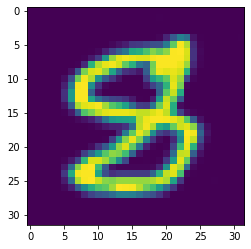

In [2]:
#load MNIST data and do some preprocessing 
data, info = tfds.load('mnist', with_info=True)
train_data, test_data = data['train'], data['test']

preprocess = lambda x: tf.cast((tf.image.resize(x['image'], (32, 32))+tf.random.uniform((32, 32, 32, 1))-0.5)/255, tf.float32)
train_data = train_data.batch(32).map(preprocess)
test_data = test_data.batch(32).map(preprocess)

x = next(iter(train_data))
plt.imshow(x[4])

(4, 4, 8)
(4, 4, 8)


2022-05-31 16:13:16.768034: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


(4, 4, 8)
(4, 4, 8)
(4, 4, 8)
(4, 4, 8)
(8, 8, 4)
(8, 8, 4)
(8, 8, 4)
(8, 8, 4)
(8, 8, 4)
(8, 8, 4)
(16, 16, 2)
(16, 16, 2)
(16, 16, 2)
(16, 16, 2)
(16, 16, 2)
(16, 16, 2)
tf.Tensor(48.480812, shape=(), dtype=float32)
tf.Tensor(
[2.7465527 2.4848368 5.1141124 3.6677456 5.170436  2.9243686 4.4567604
 3.1346638 2.6133494 4.444794  2.8894322 3.3447456 3.2723317 2.7479858
 5.009589  4.5207253 3.4891775 4.421683  3.2885466 3.803476  5.0752616
 2.7573254 3.0749178 4.028736  2.5733175 3.0451198 4.215784  2.6326113
 3.1428924 2.1279304 4.849844  3.9454424], shape=(32,), dtype=float32)
tf.Tensor(3.594203, shape=(), dtype=float32)


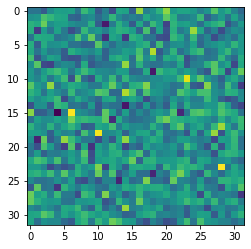

In [3]:
#define and test our bijector
glow = tfglow.Glow(output_shape=[32, 32, 1],
                coupling_bijector_fn=Resnet2GlowNetwork,
                exit_bijector_fn=tfb.GlowDefaultExitNetwork,
                num_glow_blocks=3,
                num_steps_per_block=6,
                use_actnorm=False)

z_shape = glow.inverse_event_shape([32, 32, 1])

pz = tfd.Sample(tfd.Normal(0., 1.), z_shape)

# Calling glow on distribution p(z) creates our glow distribution over images.
px = glow(pz)

# Take samples from the distribution to get images from your dataset
images = px.sample(2)

plt.imshow(images[0])
# Map images to positions in the distribution
z = glow.inverse(x)
print(tf.reduce_mean(tf.reduce_sum(tf.math.pow(glow.inverse(x), 2), axis=(1))/2))
print(glow.inverse_log_det_jacobian(x))
print(tf.reduce_mean(glow.inverse_log_det_jacobian(x)))

In [4]:
#with tf.GradientTape() as tape:
#   outputs = glow.inverse(inputs)

In [5]:
#define and test loss
@tf.function
def loss():
    return tf.reduce_mean(tf.reduce_sum(tf.math.pow(glow.inverse(x), 2), axis=(1))/2) - tf.reduce_mean(glow.inverse_log_det_jacobian(x))


for target in train_data.take(1):
    targets = target
print(targets.shape)
with tf.GradientTape() as tape:
    log_prob_loss = loss()
grads = tape.gradient(log_prob_loss, glow.trainable_variables)
print(log_prob_loss)

2022-05-31 16:13:24.177152: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(32, 32, 32, 1)
tf.Tensor(44.88661, shape=(), dtype=float32)


In [6]:
#define optimiser, summary and metrics

class MyLRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, initial_learning_rate):
        self.initial_learning_rate = initial_learning_rate

    def __call__(self, step):
        if step<=500:
            return self.initial_learning_rate 
        elif step<=1000:
            return self.initial_learning_rate/2
        elif step<=1500:
            return self.initial_learning_rate/5
        else:
            return self.initial_learning_rate/10


optimizer = tf.optimizers.Adam(learning_rate=MyLRSchedule(5e-4)) 

log = tf.summary.create_file_writer('checkpoints')
avg_loss = tf.keras.metrics.Mean(name='loss', dtype=tf.float32)
loss_list=[]
steps_list=[0]

epoch 0
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=1010> Loss -4389.262695
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=1020> Loss -4444.362305
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=1030> Loss -4490.729004
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=1040> Loss -4528.738281
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=1050> Loss -4557.609375
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=1060> Loss -4579.909180
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=1070> Loss -4597.904785
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=1080> Loss -4613.627930
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=1090> Loss -4627.913086
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=1100> Loss -4640.614258
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=1110> Loss -4537.194336
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=1120> Lo

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=1990> Loss -4868.879395
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=2000> Loss -4842.696777


2022-05-31 16:47:22.960527: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


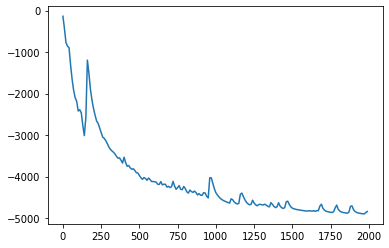

In [13]:
#training loop
n_epochs = 1
n_steps=1000

flag = False
for epoch in range(n_epochs):
    print("epoch", epoch)
    if flag:
        print('raise NaN')
        break
    for x in train_data:
        with tf.GradientTape() as tape:
            log_prob_loss = loss()
        grads = tape.gradient(log_prob_loss, glow.trainable_variables)
        optimizer.apply_gradients(zip(grads, glow.trainable_variables))
        if tf.math.is_nan(log_prob_loss):
            flag=True
            break
        avg_loss.update_state(log_prob_loss)
        if tf.equal(optimizer.iterations % 10, 0):
            print("Step {} Loss {:.6f}".format(optimizer.iterations, avg_loss.result()))
            loss_list.append(avg_loss.result())
            steps_list.append(steps_list[-1]+10)
            avg_loss.reset_states()
        #if tf.equal(optimizer.iterations % 10, 0):
        #    with log.as_default():
        #        tf.summary.scalar("loss", avg_loss.result(), step=optimizer.iterations)
        #        avg_loss.reset_states()
        if tf.equal(optimizer.iterations % n_steps, 0):
            break

plt.figure()
plt.plot(steps_list[:-1], loss_list)

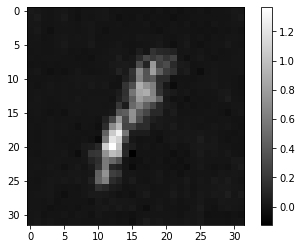

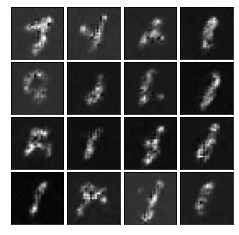

In [14]:
pz = tfd.Sample(tfd.Normal(0., 1), z_shape)
px = glow(pz)

# Take samples from the distribution to get images from your dataset
images = px.sample(2)

plt.imshow(images[0], cmap='gray')
plt.colorbar()

import utils
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
x_samples_np=px.sample(16)
utils.plot_4x4_grid(x_samples_np, shape=x_samples_np.shape[1:3])

In [ ]:
%load_ext tensorboard

In [ ]:
#z = glow(np.zeros((1024)))
#x0 = glow(z)
#plt.imshow(x0[0], cmap='gray')
#plt.colorbar()

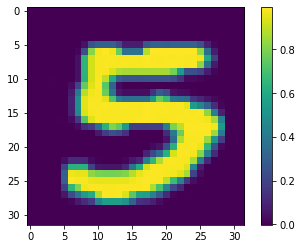

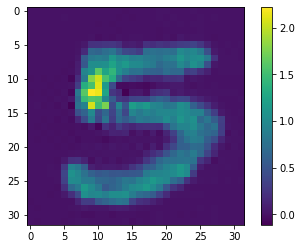

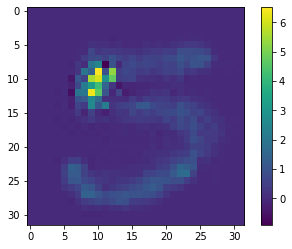

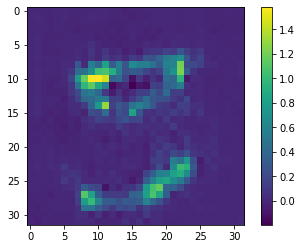

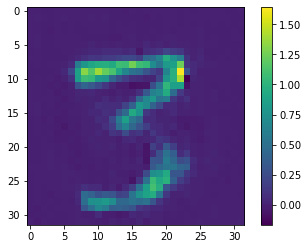

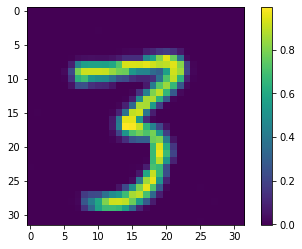

In [12]:
#Test mixing of two images from a batch
z=glow.inverse(x.numpy()).numpy()
z1=np.copy(z[3])
z2=np.copy(z[7])
z[0]=z1
a=0.9
z[1]=(z1*a+z2*(1-a))
a=0.75
z[2]=(z1*a+z2*(1-a))
a=0.5
z[3]=(z1*a+z2*(1-a))
a=0.25
z[4]=(z1*a+z2*(1-a))
a=0.1
z[5]=(z1*a+z2*(1-a))
z[6]=z2

plt.figure()
plt.imshow(glow(z)[0, :, :, 0])
plt.colorbar()
plt.figure()
plt.imshow(glow(z)[1, :, :, 0])
plt.colorbar()
plt.figure()
plt.imshow(glow(z)[2, :, :, 0])
plt.colorbar()
plt.figure()
plt.imshow(glow(z)[4, :, :, 0])
plt.colorbar()
plt.figure()
plt.imshow(glow(z)[5, :, :, 0])
plt.colorbar()
plt.figure()
plt.imshow(glow(z)[6, :, :, 0])
plt.colorbar()


In [ ]:
tf.reduce_mean(glow.inverse_log_det_jacobian(x))

In [ ]:
tf.reduce_mean(tf.reduce_sum(tf.math.pow(glow.inverse(x), 2), axis=(1))/2)

In [ ]:
tf.reduce_mean(glow.inverse_log_det_jacobian(x))

In [ ]:
loss()

In [ ]:
tf.reduce_mean(tf.reduce_sum(tf.math.pow(glow.inverse(x), 2), axis=(1))/2) - tf.reduce_mean(glow.inverse_log_det_jacobian(x))

In [ ]:
loss()

In [ ]:
@tf.function
def loss1():
    return tf.reduce_mean(tf.reduce_sum(tf.math.pow(glow.inverse(x), 2), axis=(1))/2) - tf.reduce_mean(glow.inverse_log_det_jacobian(x))
loss1()

In [ ]:
glow.compile(optimizer='adam', loss=loss)

glow.fit(x_train, None, epochs=10, shuffle=True, validation_data=(x_test))


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce
from operator import mul
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions

data, info = tfds.load('mnist', with_info=True)
train_data, test_data = data['train'], data['test']

preprocess = lambda x: tf.cast(tf.image.resize(x['image']/255, (32, 32)), tf.float32)
train_data = train_data.batch(32).map(preprocess)
test_data = test_data.batch(32).map(preprocess)

x = next(iter(train_data))
print(x)
glow = tfb.Glow(output_shape=[32, 32, 1],
                coupling_bijector_fn=tfb.GlowDefaultNetwork,
                exit_bijector_fn=tfb.GlowDefaultExitNetwork)






In [ ]:
inputs = tf.keras.layers.Input(shape=(32, 32, 1), name='my_input')
outputs = glow.inverse(inputs)
model = MyModel(inputs, outputs)

optimizer = tf.optimizers.Adam(learning_rate=2e-5) 
model.compile(optimizer, loss=loss, steps_per_execution=10)
model.fit(train_data, epochs=2, steps_per_epoch=10)
